# 10 | Team Session: Many-image Panoramic Mosaicking
**ES143 Computer Vision, Harvard University, Fall 2020**

---
In this team coding task you will learn to:
* create panoramic mosaics with arbitrary numbers of images

When you are done: 
1. Post one or more of your panoramic mosaics to [padlet](https://padlet.com/zickler/autopano). Be sure to include your name(s) and a brief description of your methods in your post(s).
2. Before the end of the Team Session, submit a copy of your `.ipynb` and `.html` files [here](https://canvas.harvard.edu/courses/78234/assignments/423449) in Canvas. Filenames should be of the form `manyautopano_lastname_firstname.ipynb` and `manyautopano_lastname_firstname.html`.

Note that the submission deadline closes exactly at the end of the Team Session. It is important that you upload your submission before that time. No late submissions will be accepted. We strongly recommend that you and your teammates reserve the final 15 minutes of the Team Session for cleaning up and submitting your notebooks. If your solution is unfinished, you can include in your notebook a discussion of what steps you would have implemented if additional time was available. (There is a Discussion cell at the end of the notebook for this purpose.)

This notebook requires the datafile `quad.zip`, which is available on the course website. It also requires you to access the other panoramic datasets in our [shared google drive](https://drive.google.com/drive/u/0/folders/1rQ88PIhT6eyIkj1rLzw-T8m0-WpApAxU). 

## Instructions:
1. Run the notebook
2. Read it and follow the instructions, posting snapshots to [padlet](https://padlet.com/zickler/autopano) as directed.
3. Your work begins in the cell marked *WORK HERE*.

In [1]:
# Import any required libraries here
import cv2                   # OpenCV
import numpy as np           # numpy
import scipy.interpolate  # interpolation, used for questions 2, 3 and 4

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# Extract zip file 
! unzip -n ./quad.zip

Archive:  ./quad.zip


In [3]:
# Read images and convert to RGB
im1 = cv2.imread('./quad/quad_left.jpg')
im2 = cv2.imread('./quad/quad_middle.jpg')
im3 = cv2.imread('./quad/quad_right.jpg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

## Familiar Helper Functions

The next cell provides two main functions that you should read and understand, along with a couple of smaller helpers that you should already be familiar with.

`H = getH(X1, X2)` accepts two $N\times 2$ arrays of inhomogeneous 2D points, each with rows $(x,y)$, and returns a $3\times 3$ homography ${\bf H}$ that maps the points ${\bf x}_1\in$ `X1` as close as possible to the points ${\bf x}_2\in$ `X2`, that is ${\bf x}_2\approx{\bf H}{\bf x}_1$. It uses the (normalized) homogeneous least-squares algorithm described in Algorithm 4.2 of Hartley and Zisserman (Chapter 4, page 109) that you implemented yourself in a previous notebook.

`H, consensus_set = getH_ransac(X1, X2, threshold, num_iters)` instead estimates the $3\times 3$ homography ${\bf H}$ using RANSAC. The two additional arguments are the threshold for determining the consensus set of potential homography (symmetric transfer distance, measured in pixels), and the number  of RANSAC iterations. In addition to returning the homography `H`, the function returns a binary length-$N$ vector `consensus_set` that indicates the rows of `X1`,`X2` that are in the best consensus set and thus judged to be "inliers" with respect to the output homography.

In [4]:
# Convert from inhomogeneous to homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from homogeneous to inhomogeneous coordinates
def hom2in(X):
    return X[:, :2] / X[:, 2:]

# Normalizing similarity transform for HZ Algorithm 4.2
def getT(X1):
    
    assert X1.shape[1] == 2, "X1 must have 2 columns (but it has {} columns)".format(X1.shape[1])
    
    N = X1.shape[0]
    
    # Compute mean x and y
    xybar = X1.mean(axis=0, keepdims=True)
    
    # Compute the denominator of s (divided by N)
    denom = np.mean(np.sqrt(np.sum((X1 - xybar) ** 2, axis=1)))
    
    # Compute s, tx, ty
    s = np.sqrt(2) / denom
    tx = -s * xybar[0, 0]
    ty = -s * xybar[0, 1]
    
    return np.array([[s, 0, tx],
                     [0, s, ty],
                     [0, 0, 1 ]], dtype=np.float32)

# Estimate 3x3 homography from two Nx2 inhomogeneous point-sets
def getH(X1, X2):

    assert np.all(X1.shape == X2.shape), "X1 and X2 must have the same shape"
    assert X1.shape[1] == 2, "X1 and X2 must have 2 columns (but they have {} columns)".format(X1.shape[1])
    
    N = X1.shape[0]
    
    # Normalizing similarity transform for both sets of points
    T1 = getT(X1)
    T2 = getT(X2)
        
    # Get homogeneous points and apply T matrix (note that X*T' = (T*X')', where ' denotes the transpose operator)
    X1h = in2hom(X1).dot(T1.transpose())
    X2h = in2hom(X2).dot(T2.transpose())
    
    # Construct A matrix of the homogeneous linear system.        
    A11 = np.zeros((N, 3), dtype=np.float32)
    A12 =  X2h[:, 2:]  * X1h
    A13 = -X2h[:, 1:2] * X1h
    A21 = -A13
    A22 = -X2h[:, :1]  * X1h
    A23 = A11
    
    A = np.block([[A11, A12, A13],
                  [A21, A22, A23]])
    
    # Compute SVD and take last column of V (note that numpy.linalg.svd() returns V transpose)
    _, _, VT = np.linalg.svd(A)
    
    h = VT[-1, :]

    # Get H' by reshaping h
    Hp = np.reshape(h, (3, 3))
        
    # Undo the normalizing similarity transforms
    invT2Hp, _, _, _ = np.linalg.lstsq(T2, Hp, rcond=None)
    H = invT2Hp.dot(T1)
    
    return H

def getH_ransac(X1, X2, threshold, num_iters):

    assert X1.shape[1] == 2, "X1 must have 2 columns (but it has {} columns)".format(X1.shape[1])
    assert X1.shape[0] == X2.shape[0], "X1 and X2 must have the same number of rows"
    
    N = X1.shape[0] # number of correspondences
    
    best_consensus = np.zeros((1,))  # Initialize as zeros so its sum is zero
    for i in range(num_iters):
        
        # Randomly select 4 correspondences
        ind = np.random.choice(np.arange(N), size=4, replace=False)
        
        # Get homography between the 4 point pairs
        H = getH(X1[ind, :], X2[ind, :])
        
        # Apply H to X1 to get an estimate of X2
        X2_est = hom2in(in2hom(X1).dot(H.transpose()))
        
        # Apply inv(H) to X2 to get an estimate of X1. 
        # As usual, use numpy.linalg.lstsq() instead of inv().
        X1h_est, _, _, _ = np.linalg.lstsq(H, in2hom(X2).transpose(), rcond=None)
        X1_est = hom2in(X1h_est.transpose())

        # Compute distances between the true and estimated X1 points, and between the
        # true and estimated X2 points.
        X1_dists = np.sqrt(np.sum((X1_est - X1) ** 2, axis=1))
        X2_dists = np.sqrt(np.sum((X2_est - X2) ** 2, axis=1))

        distances = X1_dists + X2_dists

        # Find consensus set: Produce a binary vector of length N, where distance[j]==1
        # indicates that the j-th correspondence X1[j,:] <-> X2[j,:] is in
        # the consensus set
        consensus = (distances < threshold)

        # If size of consensus set is largest so far, use it
        if sum(consensus) > sum(best_consensus):
            best_consensus = consensus

    # Use the largest consensus set to get final least-squares estimate of homographys
    return getH(X1[best_consensus, :], X2[best_consensus, :]), best_consensus

## Example: Mosaicking a three-image set

As you already witnessed in the Class Session, the next cell implements the mosaicking pipeline for an input set of three images, where the second image is treated as the "base image" onto which the other images are warped.

`imout = mosaick_three_images(I1, I2, I3, H12, H32)`

In [5]:
def mosaick_three_images(I1, I2, I3, H12, H32):

    assert I1.shape[0] == I2.shape[0] == I3.shape[0], "All images must have the same height and width"
    assert I1.shape[1] == I2.shape[1] == I3.shape[1], "All images must have the same height and width"
    assert I1.shape[2] == I2.shape[2] == I3.shape[2], "All images must have the same number of channels"

    # To handle both grayscale and RGB images with the same code, 
    #   change HxW images to size HxWx1
    if len(I1.shape) == 2:
        I1 = I1[..., np.newaxis]
        I2 = I2[..., np.newaxis]
        I3 = I3[..., np.newaxis]

    h, w = I1.shape[:2]
    num_channels = I1.shape[2]
    
    # Coordinates of single-image corners
    corners = np.array([[0,   0],
                        [0,   h-1],
                        [w-1, 0],
                        [w-1, h-1]], dtype=np.float32)

    # Apply both homographies to compute warped corner coordinates in
    #   all three images
    cornersH12 = hom2in(in2hom(corners).dot(H12.transpose()))
    cornersH32 = hom2in(in2hom(corners).dot(H32.transpose()))
    
    # Find minimal and maximal transformed corner coordinates
    cornersH = np.concatenate([corners, cornersH12, cornersH32], axis=0)
    xymin = cornersH.min(axis=0)
    xymax = cornersH.max(axis=0)
 
    # Define grid of output pixel locations and convert to homogeneous coordinates
    x, y = np.meshgrid(np.arange(xymin[0], xymax[0]), np.arange(xymin[1], xymax[1]))
    xy2 = np.concatenate([x.flatten()[:, np.newaxis], 
                          y.flatten()[:, np.newaxis]], axis=1)  # Shape = Nx2
    xy2h = in2hom(xy2)
    
    # Apply inverse of homographies H12, H13 to obtain coordinates in input images 
    #   that coorespond to each ouput pixel
    # (As usual, use numpy.linalg.lstsq() instead of inv().)
    xy1h, _, _, _ = np.linalg.lstsq(H12, xy2h.transpose(), rcond=None)
    xy1 = hom2in(xy1h.transpose())
    xy3h, _, _, _ = np.linalg.lstsq(H32, xy2h.transpose(), rcond=None)
    xy3 = hom2in(xy3h.transpose())

    # Initialize output image
    Iout = np.zeros((x.shape[0], x.shape[1], num_channels), dtype=I1.dtype)
    
    # Populate Iout one channel at a time. For each output pixel, retrieve values
    # from all three input images and then use the median of those. Use NaNs
    # to indicate when one of the warped input image does not cover that pixel.  
    for c in range(num_channels):

        # create interpolator obects. Fill out-of-bounds value with NaNs.
        interpolator12 = scipy.interpolate.RegularGridInterpolator((np.arange(h), 
                                                                    np.arange(w)),
                                                                   I1[:, :, c], 
                                                                   bounds_error=False, 
                                                                   fill_value=np.nan)

        interpolator22 = scipy.interpolate.RegularGridInterpolator((np.arange(h), 
                                                                    np.arange(w)),
                                                                   I2[:, :, c], 
                                                                   bounds_error=False, 
                                                                   fill_value=np.nan)
        
        interpolator32 = scipy.interpolate.RegularGridInterpolator((np.arange(h), 
                                                                    np.arange(w)),
                                                                   I3[:, :, c], 
                                                                   bounds_error=False, 
                                                                   fill_value=np.nan)
        
        # interpolate
        Iout1c = np.reshape(interpolator12(xy1[:, ::-1]), x.shape)
        Iout2c = np.reshape(interpolator22(xy2[:, ::-1]), x.shape)
        Iout3c = np.reshape(interpolator32(xy3[:, ::-1]), x.shape)
        
        # Per-pixel median, ignoring NaNs
        Ioutnanc = np.nanmedian(np.stack([Iout1c, Iout2c, Iout3c], axis=0), axis=0)
        
        # Replace NaNs with 0 and save to the correct channel of Iout
        Ioutnanc[Ioutnanc == np.nan] = 0
        Iout[:, :, c] = Ioutnanc
        
    return Iout

## Example: Automatically mosaicking the quad dataset

You've already seen the next cell, too. It runs the SIFT detector on each image in the dataset and performs SIFT matching between the base image (Image 2) and each of the other images. In each case it uses the symmetric matching constraint (`crossCheck=True`), and it keeps the top 20% of matches as determined by the L2-difference between descriptor vectors. 

Once all of this matching is done, it calls `getH_ransac()` twice to estimate the two homographies and then `mosaick_three_images()` to create the mosaic.

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(-0.5, 1640.5, 539.5, -0.5)

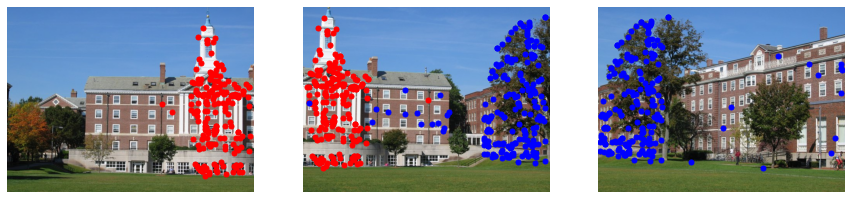

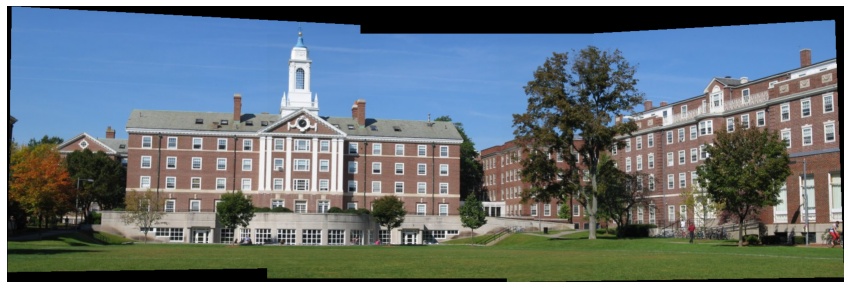

In [6]:
GOOD_MATCH_PERCENT=0.2   # top % of matches to keep between two images
THRESHOLD = 5            # inlier threshold for RANSAC
NUM_ITERS = 100          # number of iterations for RANSAC

# Create a SIFT object
sift = cv2.SIFT_create()

# Get SIFT keypoints and descriptors for each image
kp1, des1 = sift.detectAndCompute(cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY), None)
kp2, des2 = sift.detectAndCompute(cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY), None)
kp3, des3 = sift.detectAndCompute(cv2.cvtColor(im3, cv2.COLOR_RGB2GRAY), None)

# Create a "brute force" matcher object using the L2 norm,
#  and using "cross check" to only keep symmetric matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Find matches between images 1->2 and images 3->2
# Notes:
#   - The output is a list of openCV "Dmatch" objects, which are described here:
#     https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
#   - Each entry of the output list represents a match between the input 
#     descriptor-sets and includes these three attributes 
#         matches12[i].distance - Distance between matched descriptors. The lower, the better it is.
#         matches12[i].queryIdx - Index of descriptor in first set (des1 or des3 here)
#         matches12[i].trainIdx - Index of descriptor in second set (des2 here)
#     (OpenCV's use of the names "train" and "query" here is particulary unintuitive.)
matches12 = bf.match(des1, des2)
matches32 = bf.match(des3, des2)

# Sort matches in the order of increasing match-distance; keep top ones
matches12 = sorted(matches12, key = lambda x:x.distance)
numGoodMatches = int(len(matches12) * GOOD_MATCH_PERCENT)
matches12 = matches12[:numGoodMatches]

matches32 = sorted(matches32, key = lambda x:x.distance)
numGoodMatches = int(len(matches32) * GOOD_MATCH_PERCENT)
matches32 = matches32[:numGoodMatches]

# Get pixel coordinates of the surving matches
X12 = np.array([kp1[match.queryIdx].pt for match in matches12])
X21 = np.array([kp2[match.trainIdx].pt for match in matches12])
X32 = np.array([kp3[match.queryIdx].pt for match in matches32])
X23 = np.array([kp2[match.trainIdx].pt for match in matches32])

# estimate two homographies
H12,_ = getH_ransac(X12, X21, THRESHOLD, NUM_ITERS)
H32,_ = getH_ransac(X32, X23, THRESHOLD, NUM_ITERS)
  
imout = mosaick_three_images(im1, im2, im3, H12, H32)

# Plot points overlaid on images
_, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
ax1.imshow(im1)
ax1.plot(X12[:, 0], X12[:, 1], '.r', markersize=10)
ax1.axis('off')
ax2.imshow(im2)
ax2.plot(X21[:, 0], X21[:, 1], '.r', markersize=10)
ax2.plot(X23[:, 0], X23[:, 1], '.b', markersize=10)
ax2.axis('off')
ax3.imshow(im3)
ax3.plot(X32[:, 0], X32[:, 1], '.b', markersize=10)
ax3.axis('off')

# Plot mosaick
f, ax = plt.subplots(figsize=(15,10))
ax.imshow(imout)
ax.axis('off')

## WORK HERE

Your team's task is to write a new function in the cell below, possibly with some smaller functions to help it, that generalizes the example above to handle mosaicks that have an arbitray number of input images. Your main function should have the syntax

```python
def autopano(imtuple, match_percentage, ransac_threshold, ransac_iters):

    return imout
```

where the inputs and outputs are as follows:
* `imtuple`: A tuple of numpy arrays, with each numpy array storing an image. All numpy arrays in the tuple can be assumed to be of the same size (i.e., $H\times W\times $ num_channels). The first entry in the tuple should be treated as the base image, onto which the remaining images are mapped.
* `match_percentage`: a float between 0 and 1 that represents the fraction of highest-scoring SIFT matches to be kept when matching the interest points between a pair of images. (This is analogous to `GOOD_MATCH_PERCENT` in the example above.)
* `ransac_threshold`: The threshold used to determine the consensus set in RANSAC.
* `ransac_iters`": the number of RANSAC iterations.
* `imout`: the output panoramic mosaick.

For example, to reproduce the example mosaick above, one would make this call to your function:

`imout = autopano((im2,im1,im3), 0.2, 5, 100)`.

Once you test your function using the `quad` dataset to verify that it works, apply it to some of the datasets in our [shared google drive](https://drive.google.com/drive/u/0/folders/1rQ88PIhT6eyIkj1rLzw-T8m0-WpApAxU). Post some snapshots of your results to [padlet](https://padlet.com/zickler/autopano), including your team name in the title of your posts and a description of the parameters that you used.

_Tips and suggestions:_
* It is a good idea to break your main function into sub-functions that can be implemented and tested separately. For example, one sub-function could be `X1,X2 = automatch(im1,im2, match_percentage)` that performs SIFT detection and matching between two images `im1` to `im2` and returns two $N\times 2$ arrays for the top-scoring symmetric matches.
* automatically reading all of the images from a folder into a tuple can be conveniently automated using `glob`, something like this

```python
import glob
import cv2

images = [cv2.imread(file) for file in glob.glob("path/to/files/*.jpg")]
```


In [7]:
# def mosaick_two_images(I1, I2, H12, H32):

#     assert I1.shape[0] == I2.shape[0], "All images must have the same height and width"
#     assert I1.shape[1] == I2.shape[1], "All images must have the same height and width"
#     assert I1.shape[2] == I2.shape[2], "All images must have the same number of channels"

#     # To handle both grayscale and RGB images with the same code, 
#     #   change HxW images to size HxWx1
#     if len(I1.shape) == 2:
#         I1 = I1[..., np.newaxis]
#         I2 = I2[..., np.newaxis]

#     h, w = I1.shape[:2]
#     num_channels = I1.shape[2]
    
#     # Coordinates of single-image corners
#     corners = np.array([[0,   0],
#                         [0,   h-1],
#                         [w-1, 0],
#                         [w-1, h-1]], dtype=np.float32)

#     # Apply both homographies to compute warped corner coordinates in
#     #   all three images
#     cornersH12 = hom2in(in2hom(corners).dot(H12.transpose()))
    
#     # Find minimal and maximal transformed corner coordinates
#     cornersH = np.concatenate([corners, cornersH12], axis=0)
#     xymin = cornersH.min(axis=0)
#     xymax = cornersH.max(axis=0)
 
#     # Define grid of output pixel locations and convert to homogeneous coordinates
#     x, y = np.meshgrid(np.arange(xymin[0], xymax[0]), np.arange(xymin[1], xymax[1]))
#     xy2 = np.concatenate([x.flatten()[:, np.newaxis], 
#                           y.flatten()[:, np.newaxis]], axis=1)  # Shape = Nx2
#     xy2h = in2hom(xy2)
    
#     # Apply inverse of homographies H12, H13 to obtain coordinates in input images 
#     #   that coorespond to each ouput pixel
#     # (As usual, use numpy.linalg.lstsq() instead of inv().)
#     xy1h, _, _, _ = np.linalg.lstsq(H12, xy2h.transpose(), rcond=None)
#     xy1 = hom2in(xy1h.transpose())

#     # Initialize output image
#     Iout = np.zeros((x.shape[0], x.shape[1], num_channels), dtype=I1.dtype)
    
#     # Populate Iout one channel at a time. For each output pixel, retrieve values
#     # from all three input images and then use the median of those. Use NaNs
#     # to indicate when one of the warped input image does not cover that pixel.  
#     for c in range(num_channels):

#         # create interpolator obects. Fill out-of-bounds value with NaNs.
#         interpolator12 = scipy.interpolate.RegularGridInterpolator((np.arange(h), 
#                                                                     np.arange(w)),
#                                                                    I1[:, :, c], 
#                                                                    bounds_error=False, 
#                                                                    fill_value=np.nan)

#         interpolator22 = scipy.interpolate.RegularGridInterpolator((np.arange(h), 
#                                                                     np.arange(w)),
#                                                                    I2[:, :, c], 
#                                                                    bounds_error=False, 
#                                                                    fill_value=np.nan)
        

        
#         # interpolate
#         Iout1c = np.reshape(interpolator12(xy1[:, ::-1]), x.shape)
#         Iout2c = np.reshape(interpolator22(xy2[:, ::-1]), x.shape)
#         Iout3c = np.reshape(interpolator32(xy3[:, ::-1]), x.shape)
        
#         # Per-pixel median, ignoring NaNs
#         Ioutnanc = np.nanmedian(np.stack([Iout1c, Iout2c, Iout3c], axis=0), axis=0)
        
#         # Replace NaNs with 0 and save to the correct channel of Iout
#         Ioutnanc[Ioutnanc == np.nan] = 0
#         Iout[:, :, c] = Ioutnanc
        
#     return Iout

In [12]:
def turtle(im1, im2, match_percentage, ransac_threshold, ransac_iters):    
    GOOD_MATCH_PERCENT = match_percentage   # top % of matches to keep between two images
    THRESHOLD = ransac_threshold           # inlier threshold for RANSAC
    NUM_ITERS = ransac_iters          # number of iterations for RANSAC
    # Create a SIFT object
    sift = cv2.SIFT_create()
    # Get SIFT keypoints and descriptors for each image
    kp1, des1 = sift.detectAndCompute(cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY), None)
    # Create a "brute force" matcher object using the L2 norm,
    #  and using "cross check" to only keep symmetric matches
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Find matches between images 1->2 and images 3->2
    # Notes:
    #   - The output is a list of openCV "Dmatch" objects, which are described here:
    #     https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    #   - Each entry of the output list represents a match between the input 
    #     descriptor-sets and includes these three attributes 
    #         matches12[i].distance - Distance between matched descriptors. The lower, the better it is.
    #         matches12[i].queryIdx - Index of descriptor in first set (des1 or des3 here)
    #         matches12[i].trainIdx - Index of descriptor in second set (des2 here)
    #     (OpenCV's use of the names "train" and "query" here is particulary unintuitive.)
    matches12 = bf.match(des1, des2)
    # Sort matches in the order of increasing match-distance; keep top ones
    matches12 = sorted(matches12, key = lambda x:x.distance)
    numGoodMatches = int(len(matches12) * GOOD_MATCH_PERCENT)
    matches12 = matches12[:numGoodMatches]
    # Get pixel coordinates of the surving matches
    X12 = np.array([kp1[match.queryIdx].pt for match in matches12])
    X21 = np.array([kp2[match.trainIdx].pt for match in matches12])
    # estimate two homographies
    H12,_ = getH_ransac(X12, X21, THRESHOLD, NUM_ITERS)
    # FOR IM1:
    h1, w1 = im1.shape[:2]
    num_channels = im1.shape[2]
    # Coordinates of single-image corners
    corners1 = np.array([[0,   0],
                        [0,   h1-1],
                        [w1-1, 0],
                        [w1-1, h1-1]], dtype=np.float32)
    # FOR IM2:
    h2, w2 = im2.shape[:2]
    num_channels = im2.shape[2]
    # Coordinates of single-image corners
    corners2 = np.array([[0,   0],
                        [0,   h1-1],
                        [w1-1, 0],
                        [w1-1, h1-1]], dtype=np.float32)
    # Apply both homographies to compute warped corner coordinates in
    #   all three images
    cornersH12 = hom2in(in2hom(corners1).dot(H12.transpose()))
    # Find minimal and maximal transformed corner coordinates
    cornersH = np.concatenate([corners1, cornersH12], axis=0)
    xymin = cornersH.min(axis=0)
    xymax = cornersH.max(axis=0)
    # Define grid of output pixel locations and convert to homogeneous coordinates
    x, y = np.meshgrid(np.arange(xymin[0], xymax[0]), np.arange(xymin[1], xymax[1]))
    xy2 = np.concatenate([x.flatten()[:, np.newaxis], 
                          y.flatten()[:, np.newaxis]], axis=1)  # Shape = Nx2
    xy2h = in2hom(xy2)
    # Apply inverse of homographies H12, H13 to obtain coordinates in input images 
    #   that coorespond to each ouput pixel
    # (As usual, use numpy.linalg.lstsq() instead of inv().)
    xy1h, _, _, _ = np.linalg.lstsq(H12, xy2h.transpose(), rcond=None)
    xy1 = hom2in(xy1h.transpose())
    # Initialize output image
    Iout = np.zeros((x.shape[0], x.shape[1], num_channels), dtype=im1.dtype)
    # Populate Iout one channel at a time. For each output pixel, retrieve values
    # from all three input images and then use the median of those. Use NaNs
    # to indicate when one of the warped input image does not cover that pixel.  
    for c in range(num_channels):
        # create interpolator obects. Fill out-of-bounds value with NaNs.
        interpolator12 = scipy.interpolate.RegularGridInterpolator((np.arange(h1), 
                                                                    np.arange(w1)),
                                                                   im1[:, :, c], 
                                                                   bounds_error=False, 
                                                                   fill_value=np.nan)
        interpolator22 = scipy.interpolate.RegularGridInterpolator((np.arange(h2), 
                                                                    np.arange(w2)),
                                                                   im2[:, :, c], 
                                                                   bounds_error=False, 
                                                                   fill_value=np.nan)
        # interpolate
        Iout1c = np.reshape(interpolator12(xy1[:, ::-1]), x.shape)
        Iout2c = np.reshape(interpolator22(xy2[:, ::-1]), x.shape)
        # Per-pixel median, ignoring NaNs
        Ioutnanc = np.nanmedian(np.stack([Iout1c, Iout2c], axis=0), axis=0)
        # Replace NaNs with 0 and save to the correct channel of Iout
        Ioutnanc[Ioutnanc == np.nan] = 0
        Iout[:, :, c] = Ioutnanc
    return Iout

In [13]:
def autopano(imtuple, match_percentage, ransac_threshold, ransac_iters):
    imout = imtuple[0]
    for i, img in enumerate(imtuple[1:]):
        if i % 2 == 1:
            imout = turtle(img, imout, match_percentage, ransac_threshold, ransac_iters)
        else:
            imout = turtle(imout, img, match_percentage, ransac_threshold, ransac_iters)
    return imout

In [14]:
# def autopano(imtuple, match_percentage, ransac_threshold, ransac_iters):

#     imout=[]
#     kps = []
#     descs = []
    
#     # get all the interespoints 
#     for img in imtuple:
#         kp_tmp, des_tmp = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
#         kps.append(kp_tmp)
#         descs.append(des_tmp)
        
    
#     bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
#     center_img_idx = len(imtuple) // 2
    
    
#     for desc1, desc2  in zip(descs[::2], descs[1::2]):
#         matches = bf.match(descs1, descs2)
#         # Sort matches in the order of increasing match-distance; keep top ones
#         matches = sorted(matches, key = lambda x:x.distance)
#         numGoodMatches = int(len(matches) * match_percentage)
#         matches = matches[:numGoodMatches]
        
#         # Get pixel coordinates of the surving matches
#         X12 = np.array([kp1[match.queryIdx].pt for match in matches])
#         X21 = np.array([kp2[match.trainIdx].pt for match in matches])
        
#         H12,_ = getH_ransac(X12, X21, THRESHOLD, NUM_ITERS)
        

        
        
    
    
    
#     return imout

In [17]:
import os

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


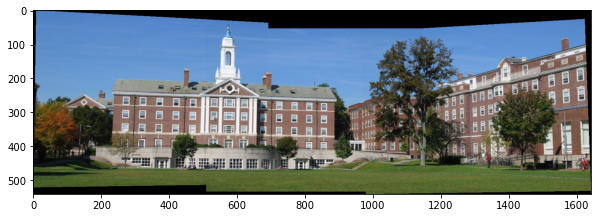

In [15]:
plt.imshow(autopano([im1,im2,im3], 0.2,5,100))

In [23]:
house_imgs = []
for img_t in sorted(os.listdir("./house")):
    print(img_t)
    
    im_tmp = cv2.imread(img_t)
    im_tmp = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
    house_imgs.append(img_t)


house_01.jpg


TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [ ]:
plt.imshow(autopano(house_imgs, 0.2,5,100))

## Discussion

Optional: Your text here.